In [191]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Features
Variable | Definition | Key
:-:|:-:|:-:
survival | Survival | 0 = No, 1 = Yes
pclass | Ticket class(客舱等级) | 1 = 1st, 2 = 2nd, 3 = 3rd
sex | Sex
Age | Age in years
sibsp | # of siblings / spouses aboard the Titanic(旁系亲属)
parch | # of parents / children aboard the Titanic(直系亲属)
ticket | Ticket number
fare | Passenger fare
cabin | Cabin number(客舱编号)
embarked | Port of Embarkation(上船的港口编号) | C = Cherbourg, Q = Queenstown, S = Southampton

In [192]:
train = pd.read_csv("./kaggle/input/titanic/train.csv")
test = pd.read_csv("./kaggle/input/titanic/test.csv")
allData = pd.concat([train, test], ignore_index=True)
# dataNum = train.shape[0]
# featureNum = train.shape[1]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


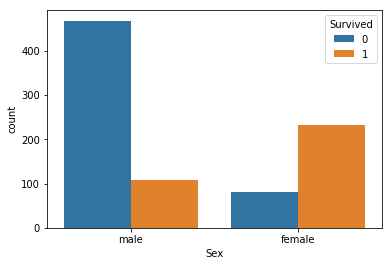

In [193]:
# Sex
sns.countplot('Sex', hue='Survived', data=train)
plt.show()

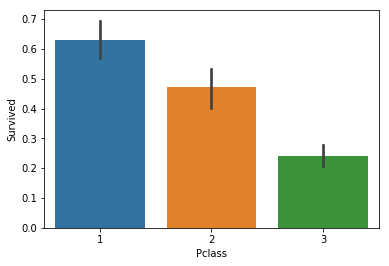

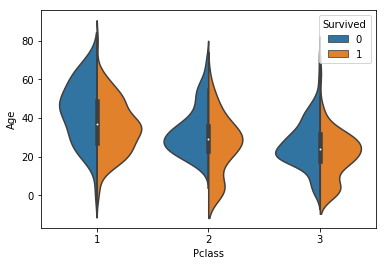

In [194]:
# Pclass
sns.barplot(x='Pclass', y="Survived", data=train)
plt.show()
# Pclass & Age
sns.violinplot("Pclass", "Age", hue="Survived", data=train, split=True)
plt.show()

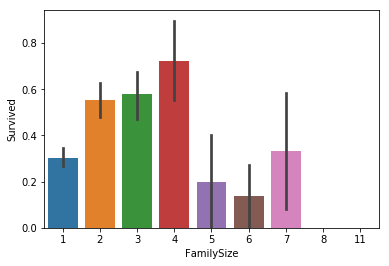

In [195]:
# FamilySize = SibSp + Parch + 1
# FamilyLabel 0 1 2
allData['FamilySize'] = allData['SibSp'] + allData['Parch'] + 1
sns.barplot(x='FamilySize', y='Survived', data=allData)
plt.show()

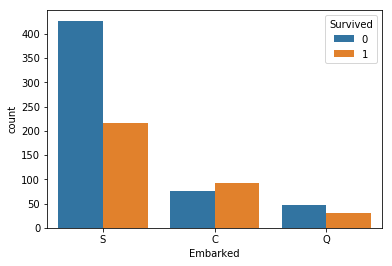

In [196]:
# Embarked
sns.countplot('Embarked', hue='Survived', data=train)
plt.show()

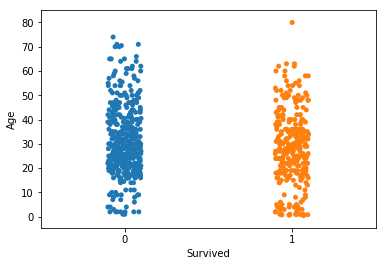

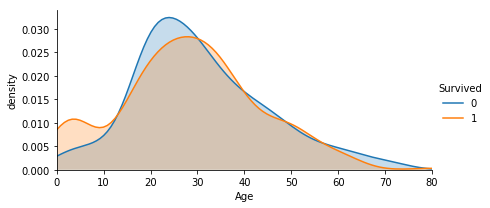

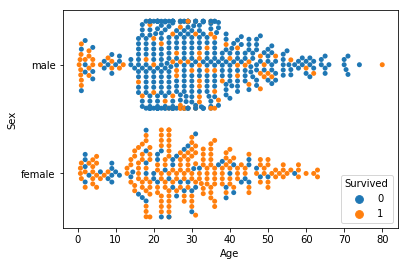

In [197]:
# Age
sns.stripplot(x="Survived", y="Age", data=train, jitter=True)
plt.show()
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.xlabel('Age') 
plt.ylabel('density') 
plt.show()
# Age & Sex
sns.swarmplot(x='Age', y="Sex", data=train, hue='Survived')
plt.show()

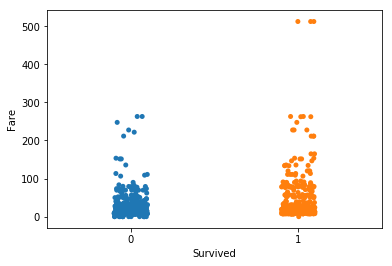

In [198]:
# Fare
sns.stripplot(x="Survived", y="Fare", data=train, jitter=True)
plt.show()

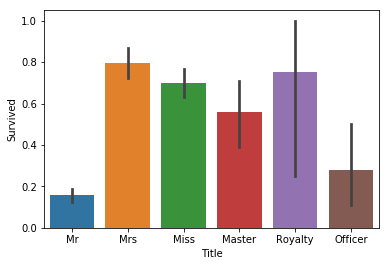

In [199]:
# Name
# allData['Title'] = allData['Name'].str.extract('([A-Za-z]+)\.', expand=False) # str.extract不知道在干嘛
allData['Title'] = allData['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
# pd.crosstab(allData['Title'], allData['Sex'])
TitleClassification = {'Officer':['Capt', 'Col', 'Major', 'Dr', 'Rev'],
                       'Royalty':['Don', 'Sir', 'the Countess', 'Dona', 'Lady'],
                       'Mrs':['Mme', 'Ms', 'Mrs'],
                       'Miss':['Mlle', 'Miss'],
                       'Mr':['Mr'],
                       'Master':['Master','Jonkheer']}
TitleMap = {}
for title in TitleClassification.keys():
    TitleMap.update(dict.fromkeys(TitleClassification[title], title))
    '''
    # cnt = 0
    for name in TitleClassification[title]:
        cnt += allData.groupby(['Title']).size()[name]
    # print (title,':',cnt)
    '''
allData['Title'] = allData['Title'].map(TitleMap)
sns.barplot(x="Title", y="Survived", data=allData)
plt.show()

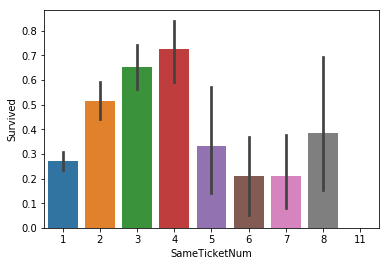

In [200]:
TicketCnt = allData.groupby(['Ticket']).size()
allData['SameTicketNum'] = allData['Ticket'].apply(lambda x:TicketCnt[x])
sns.barplot(x='SameTicketNum', y='Survived', data=allData)
plt.show()
# allData['SameTicketNum']

# 数据清洗
- Sex & Pclass & Embarked --> Ont-Hot
- Age & Fare --> Standardize
- FamilySize & Name & Ticket --> ints --> One-Hot

In [201]:
# Sex
allData = allData.join(pd.get_dummies(allData['Sex'], prefix="Sex"))
# Pclass
allData = allData.join(pd.get_dummies(allData['Pclass'], prefix="Pclass"))
# Embarked
allData[allData['Embarked'].isnull()] # 查看缺失值
allData.groupby(by=['Pclass','Embarked']).Fare.mean() # Pclass=1, Embark=C, 中位数=76
allData['Embarked'] = allData['Embarked'].fillna('C')
allData = allData.join(pd.get_dummies(allData['Embarked'], prefix="Embarked"))

In [202]:
# Age
allData['Child'] = allData['Age'].apply(lambda x:1 if x <= 10 else 0) # 儿童标签
allData['Age'] = (allData['Age']-allData['Age'].mean())/allData['Age'].std() # 标准化
allData['Age'].fillna(value=0, inplace=True) # 填充缺失值
# Fare
allData[allData['Survived'].notnull()]['Fare'] = allData[allData['Survived'].notnull()]['Fare'].apply(lambda x:300.0 if x>500 else x)
allData['Fare'] = allData['Fare'].apply(lambda x:(x-allData['Fare'].mean())/allData['Fare'].std())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [203]:
# FamilySize
def FamilyLabel(s):
    if (s == 4):
        return 4
    elif (s == 2 or s == 3):
        return 3
    elif (s == 1 or s == 7):
        return 2
    elif (s == 5 or s == 6):
        return 1
    elif (s < 1 or s > 7):
        return 0
allData['FamilyLabel'] = allData['FamilySize'].apply(FamilyLabel)
allData = allData.join(pd.get_dummies(allData['FamilyLabel'], prefix="Fam"))

# Name
TitleLabelMap = {'Mr':1.0,
                 'Mrs':5.0,
                 'Miss':4.5,
                 'Master':2.5,
                 'Royalty':3.5,
                 'Officer':2.0}
def TitleLabel(s):
    return TitleLabelMap[s]
# allData['TitleLabel'] = allData['Title'].apply(TitleLabel)
allData = allData.join(pd.get_dummies(allData['Title'], prefix="Title"))

# Ticket
def TicketLabel(s):
    if (s == 3 or s == 4):
        return 3
    elif (s == 2 or s == 8):
        return 2
    elif (s == 1 or s == 5 or s == 6 or s ==7):
        return 1
    elif (s < 1 or s > 8):
        return 0
allData['TicketLabel'] = allData['SameTicketNum'].apply(TicketLabel)
allData = allData.join(pd.get_dummies(allData['TicketLabel'], prefix="TicNum"))

In [204]:
# 清除无用特征
allData.drop(['Cabin', 'PassengerId', 'Ticket', 'Name', 'Title', 'Sex', 'SibSp', 'Parch', 'FamilySize', 'Embarked', 'Pclass', 'Title', 'FamilyLabel', 'SameTicketNum', 'TicketLabel'], axis=1, inplace=True)

# 重新分割数据集
train_data = allData[allData['Survived'].notnull()]
test_data  = allData[allData['Survived'].isnull()]
test_data = test_data.reset_index(drop=True)

xTrain = train_data.drop(['Survived'], axis=1)
yTrain = train_data['Survived']
xTest  = test_data.drop( ['Survived'], axis=1)

xTest['Fare'] = xTest['Fare'].fillna(30)

# allData.columns.to_list()

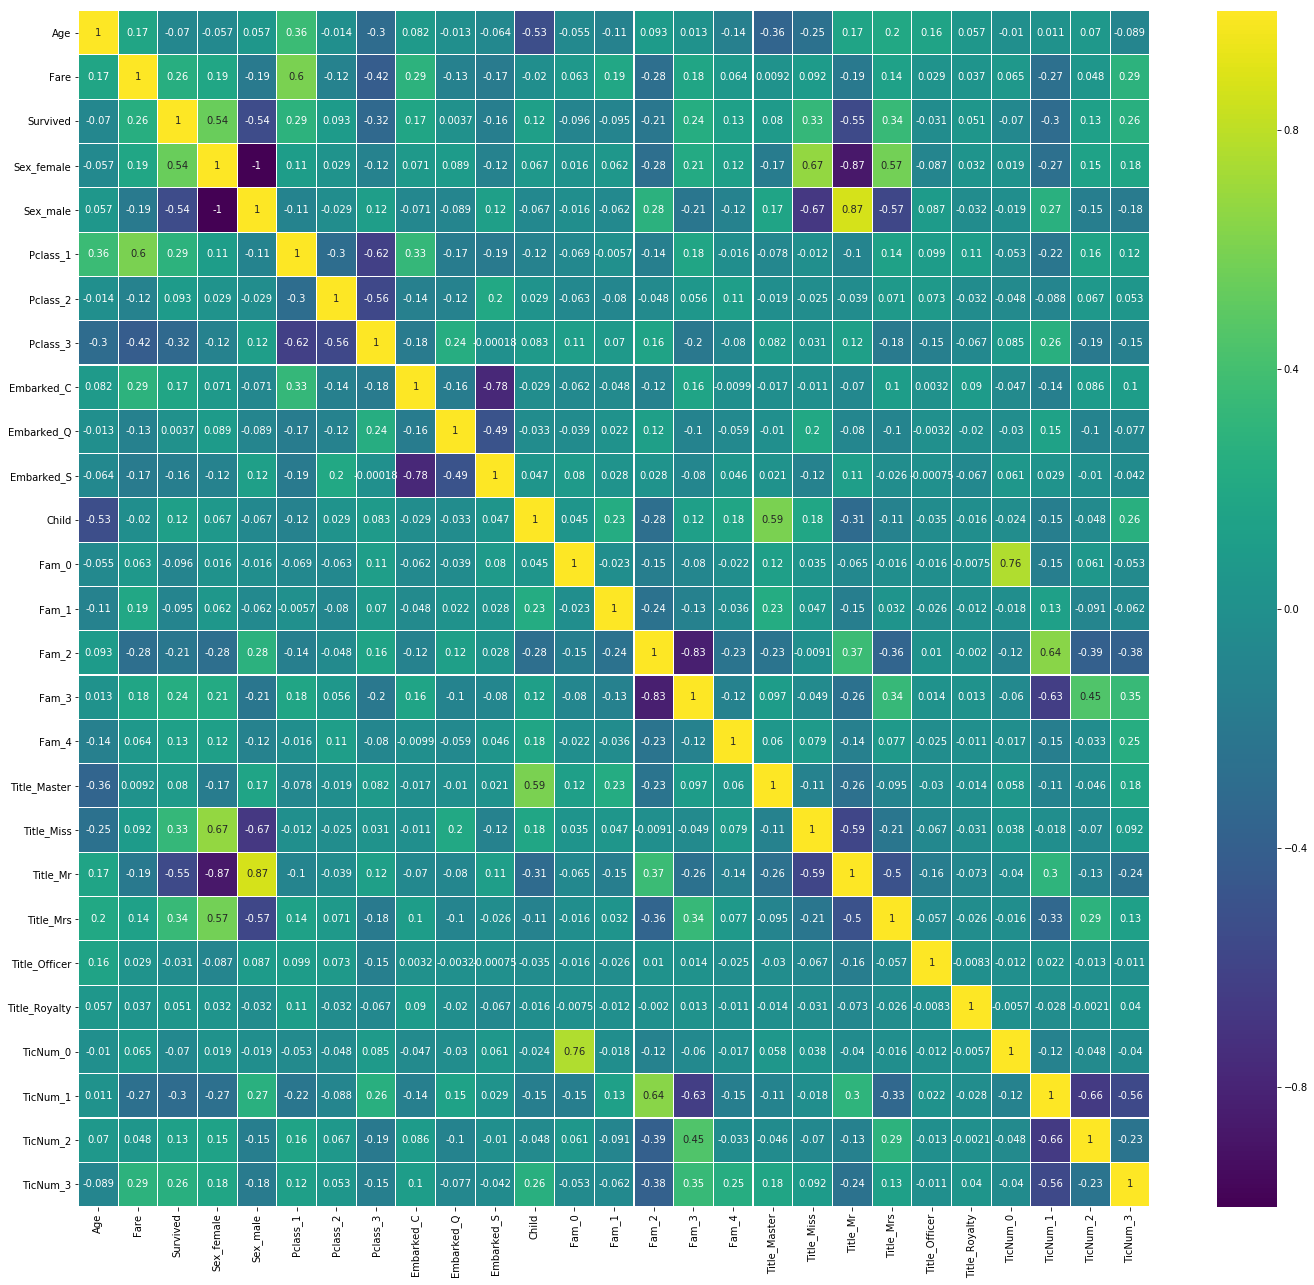

In [205]:
# 特征间相关性分析
Correlation = pd.DataFrame(allData[allData.columns.to_list()])
colormap = plt.cm.viridis
plt.figure(figsize=(24,22))
sns.heatmap(Correlation.astype(float).corr(), linewidths=0.1, vmax=1.0, cmap=colormap, linecolor='white', annot=True)
plt.show()

# 网格筛选随机森林参数
- n_estimator
- max_depth

In [206]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest

In [208]:

pipe = Pipeline([('select', SelectKBest(k=10)),
                 ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])
param_test = {'classify__n_estimators':list(range(20,100,5)),
              'classify__max_depth'   :list(range(3,10,1))}
gsearch = GridSearchCV(estimator=pipe, param_grid=param_test, scoring='roc_auc', cv=10)
gsearch.fit(xTrain, yTrain)
print (gsearch.best_params_, gsearch.best_score_)


{'classify__max_depth': 6, 'classify__n_estimators': 70} 0.8790924679681529


In [207]:
rfc = RandomForestClassifier(n_estimators=70, max_depth=6, random_state=10, max_features='sqrt')
rfc.fit(xTrain, yTrain)
predictions = rfc.predict(xTest)

output = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':predictions.astype('int64')})
output.to_csv('my_submission.csv', index=False)